In [1]:
import gymnasium as gym
import json
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn
import random



from src.Algorithms.SARSA_controlled import SARSA
from src.Algorithms.Q_learning_controlled import Q_learning
from src.Classes.Policy import Policy as Policy_V2
from src.Classes.Agent import Agent
from src.Functions.run import run_static
from src.Functions.save_or_load import save_or_load

c:\Users\Zongo\miniconda3\envs\reinforcment-learning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Algorithmes d'apprentissage

Au coeur de tous les algorithmes d'apprentissage présenté ici, il y a la matrice $Q_{s,a}$, qui est l'estimation relative (à l'algorithme) de chaque couple état-action. Plus la valeur du couple $(etat, action)$ est haute, plus elle est associé à un taux de réussite élevé, et pour un état donné (une ligne de la $Q_{s,a}$ ), la politique optimale associée choisira l'action ayant la valeur la plus haute.

On va ici distinguer deux familles d'algorithmes:
- d'une part la famille des algorithmes de Monte-Carlo, qui fonctionne dans un contexte épisodique, et qui a besoin d'un épisode complet pour mettre à jour la politique,
- d'autre part la famille des algorithmes de Temporal Difference (TD), qui mettent à jour la politique à chaque étape de l'épisode

## Methode(s) Monte-carlo

La méthode de **Monte-Carlo** (pour le *Reinforcement Learning*) est l'approche la plus "naïve" qu'on puisse avoir: pour évaluer la qualité d'un état, respectivement d'un couple état-action, on observe le "taux de réussite" de cet état, respectivement du couple état-action, après un épisode complet. 
 A l'issue de suffisamment d'épisodes, on a une estimation relative de chaque état, ou couple état-action, à partir de laquelle on peut déduire une politique "optimale".

lien pertinent: https://towardsdatascience.com/monte-carlo-learning-b83f75233f92

**Remarques**:
- Comment faire lorsqu'on ne peut pas partir de chacun des états du système (comme c'est le cas dans *Frozen-Lake*)?
- D'une certaine manière, on "se fiche" de comment l'agent parcours les états, seul l'observation des trajectoires compte
- Instinctivement, pour éviter de biaiser le parcours de l'agent, on peut utiliser une politique uniformément aléatoire (lors de la phase d'apprentissage)
- Avec le constat précédent, on peut simplement paramétrer un algoritme de Monte Carlo avec comme seul paramètre le nombre d'itération

In [2]:
with open("src/Algorithms/Monte_Carlo.py", 'r', encoding='utf-8') as the_file:
    print(the_file.read())

from src.Classes.Policy import Policy
from src.Classes.Agent import Agent

import numpy as np
import random

# Generic Initialisation
def MC(environment, epoch_number = 8000):
    # Get the observation space & the action space
    environment_space_length: int = environment.observation_space.n # type: ignore
    action_space_length: int = environment.action_space.n # type: ignore
    Q_sa = np.zeros((environment_space_length, action_space_length))
    incremental_counter = np.zeros((environment_space_length, action_space_length))
    random_policy = Policy(
        lambda agent, state: 
            random.randint(0, action_space_length - 1)
        ,
        environment_space_length,
        action_space_length
    )
    def update_MC(agent: Agent):
        # All the (state, action) pair got updated with the last reward of the run
        final_value = agent.trajectory.steps[-1].reward
        for step in agent.trajectory.steps:
            increment = incremental_counter[step.state, s

## Temporal Difference (TD)

Contrairement aux algorithmes "Monte Carlo", les algorithmes TD mettent à jour leur politique à chaque étape de chaque épisode.

**Remarques:**
- J'ai trouvé beaucoup de contradiction dans les définitions de *on-policy* et *off-policy*, celles que j'ai utilisées sont la version de wikipedia (et découlent de l'observation des méthodes de mise à jour)
- pour ces algorithmes, on aura typiquement 4 paramètres: le nombre d'itération, le facteur d'apprentissage $\alpha$, le facteur d'actualisation $\gamma$ et $\epsilon$ le facteur d'exporation de la politique $\epsilon$*-greedy*

### SARSA

L'algorithme **SARSA** tire son nom de sa méthode d'apprentissage, qui signifie *State-Action-Reward-State-Action*: à chaque pas de l'algorithme, c'est à dire à chaque fois qu'un agent choisit une action, on va mettre à jour la matrice $Q_{s, a}$ en fonction de l'état de départ, l'action choisie par la politique, la récompense fournie par l'environnement, mais également l'action suivante à l'état suivant choisi par la politique en cours. L'amélioration de $Q_{s, a}$ peut donc s'écrire comme la fonction suivante: $update\_SARSA(State_n, Action_n, Reward_n, State_{n+1}, Action_{n+1})$.

Puisque que la fonction d'amélioration dépend de l'action $Action_{n+1}$, elle même déterminée par la politique en cours, on dit qu'il s'agit d'un algorithme *on-policy*.

In [3]:
with open("src/Algorithms/SARSA.py", 'r', encoding='utf-8') as the_file:
    print(the_file.read())

from typing import Callable
import gymnasium as gym
from nptyping import Float, NDArray, Shape
import numpy as np

from src.Classes.Policy import Policy
from src.Classes.Agent import Agent
from src.Functions.epsilon_greedy_policy_factory import make_epsilon_greedy_policy

def SARSA(environment, epsilon = 0.1, alpha = 0.1, gamma = 0.99, epoch_number = 8000):
    # Get the observation space & the action space
    environment_space_length: int = environment.observation_space.n # type: ignore
    action_space_length: int = environment.action_space.n # type: ignore
    Q_sa = np.zeros((environment_space_length, action_space_length))

    epsilon_greedy_policy = Policy(
        make_epsilon_greedy_policy(epsilon = epsilon, Q_sa = Q_sa),
        environment_space_length,
        action_space_length
    )
    def update_SARSA(agent: Agent, state_index: int, action_index: int, next_state: int, next_action: int,  reward:float = 0.0):
        # Q[s, a] := Q[s, a] + α[r + γQ(s', a') - Q(s, a)]
   

### Q-learning

L'algorithme **Q_learning** ressemble beaucoup à l'algorithme **SARSA**: comme lui il va mettre à jour la matrice $Q_{s, a}$ à chaque pas (*step*) de chaque épisode. L'amélioration de $Q_{s, a}$ peut s'écrire comme la fonction suivante: $update\_Qlearning(State_n, Action_n, Reward_n, State_{n+1})$.

Contrairement à la fonction d'almélioration de **SARSA**, on voit que celle de **Q_learning** ne dépend pas de l'action $Action_{n+1}$: elle ne dépend donc pas de la politique utilisée, et on parlera alors d'un algorithme *off-policy*.

In [4]:
with open("src/Algorithms/Q_learning.py", 'r', encoding='utf-8') as the_file:
    print(the_file.read())

import gymnasium as gym
import numpy as np

from src.Classes.Policy import Policy
from src.Classes.Agent import Agent
from src.Functions.epsilon_greedy_policy_factory import make_epsilon_greedy_policy

def Q_learning(environment, epsilon = 0.1, alpha = 0.1, gamma = 0.99, epoch_number = 8000):
    # Get the observation space & the action space
    environment_space_length: int = environment.observation_space.n # type: ignore
    action_space_length: int = environment.action_space.n # type: ignore
    Q_sa = np.zeros((environment_space_length, action_space_length))

    epsilon_greedy_policy = Policy(
        make_epsilon_greedy_policy(epsilon = epsilon, Q_sa = Q_sa),
        environment_space_length,
        action_space_length
    )
    def update_Qlearning(agent: Agent, state_index, action_index, next_state, reward: float = 0):
        # Q[s, a] := Q[s, a] + α[r + γ . argmax_a {Q(s', a')} - Q(s, a)]
        best_next_action = np.argmax(Q_sa[next_state, ])
        Q_sa[state_index, act

# Comparaisons, convergence et métrique

Les temps de calcul des algorithmes seront potentiellement "long", on voudrait alors savoir quand s'arrêter avec un résultat (*i.e* une politique optimale estimée) qui soit *aussi bonne que possible*. Avant de se lancer dans une longue période d'apprentissage, on aimerait choisir judicieusement les paramètres de notre algorithme par exemple.

**Remarques:**
- La lecture de littérature sur le sujet peut donner une bonne idée de paramètres "non-déconnants", ou d'une plage de valeur pertinente
- Ici, j'aurai une approche naïve, et je choisirais ces paramètres uniquement via l'exploitation des algorithmes précédents

## Grille

Pour essayer de se faire une idée du comportement de chaque algorithme en fonction de ses paramètres, l'approche "naïve" est de faire une grille sur l'espace des paramètres. Les valeurs possibles pour $\alpha$, $\gamma$ et $\epsilon$ sont toutes dans l'intervalle $[0, 1]$, et les valeurs pour le nombre d'estimation sont les entiers positifs.

In [5]:
with open("parameter_grid.py", 'r', encoding='utf-8') as the_file:
    print(the_file.read())

import random
import gymnasium as gym
import numpy as np
import json

from src.Algorithms.SARSA import SARSA
from src.Algorithms.Q_learning import Q_learning

from src.Classes.Policy import Policy
from src.Classes.Agent import Agent
from src.Functions.run import run_static

#    ____             _                     _____             __ _                       _   _             
#   |  _ \           | |                   / ____|           / _(_)                     | | (_)            
#   | |_) | __ _  ___| | ___   _ _ __     | |     ___  _ __ | |_ _  __ _ _   _ _ __ __ _| |_ _  ___  _ __  
#   |  _ < / _` |/ __| |/ / | | | '_ \    | |    / _ \| '_ \|  _| |/ _` | | | | '__/ _` | __| |/ _ \| '_ \ 
#   | |_) | (_| | (__|   <| |_| | |_) |   | |___| (_) | | | | | | | (_| | |_| | | | (_| | |_| | (_) | | | |
#   |____/ \__,_|\___|_|\_\\__,_| .__/     \_____\___/|_| |_|_| |_|\__, |\__,_|_|  \__,_|\__|_|\___/|_| |_|
#                               | |                                 __/ |    

**Remarque:** Effectuer les calculs pour toute la grille prend du temps => on sauvegarde à chaque nouveau modèle testé les résultats dans un fichier.

## Comparaison

L'approche la plus naïve et directe pour comparer les résultats lors de la phase d'apprentissage sont les résultats obtenus lors de la phase de test correspondante avec les paramètres appris (ici, ce sera toujours la matrice $Q_{s, a}$).

Les objectifs de ces comparaisons sont multiples: quel jeux de paramètres choisir pour optimiser la convergence vers la **meilleure** matrice $Q_{s, a}$ ? Comment savoir si on a suffisement appris ? Quelle est la sensibilité de notre algorithme aux paramètres ? Quel algorithme choisir pour notre problème ?

**Attention:** Il est facile de commettre l'erreur d'évaluer notre méthode en se basant sur la politique d'apprentissage. Il faut en effet l'évaluer lors d'une phase de test sur la politique **optimale**, ici déterministe, qui sera construite *a priori* avec la matrice $Q_{s, a}$. Pour concrétiser la différence entre les deux: si je mettais un paramètre $\epsilon = 1$, est ce qu'on verrait une quelconque amélioration si on testait cette même politique ? N'ai je "rien appris" pour autant ?

### Monte-Carlo

L'algorithme d'apprentissage de Monte-Carlo implémenté est très simpliste, et peut largement être amélioré. Le seul paramètre de l'algorithme est ici le nombre d'étapes lors de la phase d'apprentissage, et le graphique suivant illustre l'évolution du taux de réussite lors de la phase de test en fonction de ce nombre d'étape.



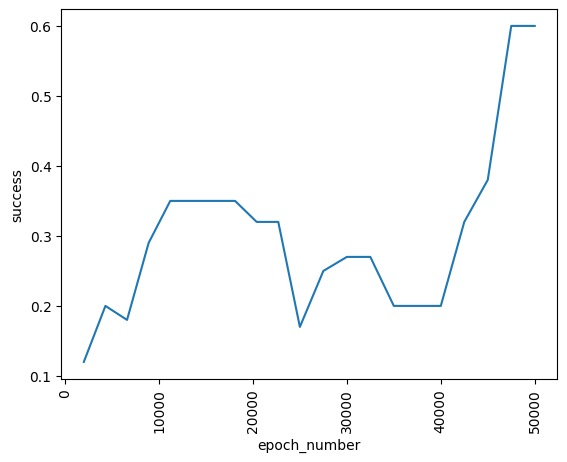

In [7]:
results = []

with open("data/mc_grid_final.json", 'r') as the_file:
    results += json.loads(the_file.read())
                          
big_df = pd.DataFrame(results)
seaborn.lineplot(big_df, x = "epoch_number", y= "success").tick_params(axis='x', rotation=90)

On observe que l'algorithme **semble converger** vers un taux de réussite de 0.6, mais qu'il lui faut "beaucoup" de d'itérations. En optimisant la politique d'apprentissage, on pourrait certainement gagner un temps "considérable".

**Remarque:** Il n'y a qu'une seule observation par valeur du paramètre **epoch_number**, mais cette valeur est le taux de réussite sur 100 tests. On pourrait augmenter la taille de l'échantillon de test si on voulait être un peu plus "sûr" de la valeur retournée, mais...

**Rappel:** Lors de chaque phase de test, l'aléatoire est remis à zéros, donc on observe bien la manière dont se comporte la politique finale (= de test) **en faisant abstraction du hasard intrinsèque**.

### Algorithmes DT

Les algorithmes SARSA et Q-learning étant tous les deux de la même catégorie, avec les mêmes jeux de paramètres, on peut effectuer la comparaison entre eux, et utiliser une grille de paramètres communes. Cela peut permettre par exemple de décider quel algorithme utiliser entre les deux.



In [8]:
results = []

with open("data/fat_grid_2.json", 'r') as the_file:
    results += json.loads(the_file.read())
                          
big_df = pd.DataFrame(results)
print(big_df)

       algorithm  success  epoch_number  epsilon  alpha     gamma  \
0          SARSA     0.08        2000.0     0.50   0.10  0.800000   
1     Q_learning     0.18        2000.0     0.50   0.10  0.800000   
2          SARSA     0.13        2000.0     0.50   0.10  0.825714   
3     Q_learning     0.22        2000.0     0.50   0.10  0.825714   
4          SARSA     0.22        2000.0     0.50   0.10  0.851429   
...          ...      ...           ...      ...    ...       ...   
8187  Q_learning     0.08        8000.0     0.98   0.98  0.928571   
8188       SARSA     0.33        8000.0     0.98   0.98  0.954286   
8189  Q_learning     0.08        8000.0     0.98   0.98  0.954286   
8190       SARSA     0.14        8000.0     0.98   0.98  0.980000   
8191  Q_learning     0.08        8000.0     0.98   0.98  0.980000   

                                                   q_sa  
0     [[0.004866050347305372, 0.004785138234355717, ...  
1     [[0.010236405259126497, 0.009669868145180921, ...

Contrairement à la méthode de Monte Carlo étudié précedemment, on a ici 4 paramètres a tester/évaluer/comprendre. Dans un premier temps, on peut réaliser une approche **univarié**, c'est à dire regarder l'impact du taux de réussite en faisant varier un seul parmètre.

En amalgamant sur l'ensemble des autres paramètres, on peut tracer le graphique d'une *violinplot* de l'évolution du taux de réussite en fonction du paramètre d'intérêt.

**Remarque:** Une *violinplot* est la combinaison d'une boîte à moustache, qui représente la distribution "synthétique" d'une variable par rapport à une autre, et de la densité par rapport à cette même variable. Ainsi le point blanc central représente la médiane, et les barres délimitent les quartiles de la distribution, les points à l'extérieur étant supposés être des *outliers* (foncièrement faux dans notre cas, car le taux de succès n'est pas une variable observée sur laquelle on pourrait faire une erreur de mesure). Ce dernier comportement, à propos des *outliers* n'est pas forcément satisfaisant pour l'analyse, et se comporte différement sur d'autres programmes d'analyse statistique, comme **R**. 

Pour le nombre d'*epoch* lors de l'apprentissage:

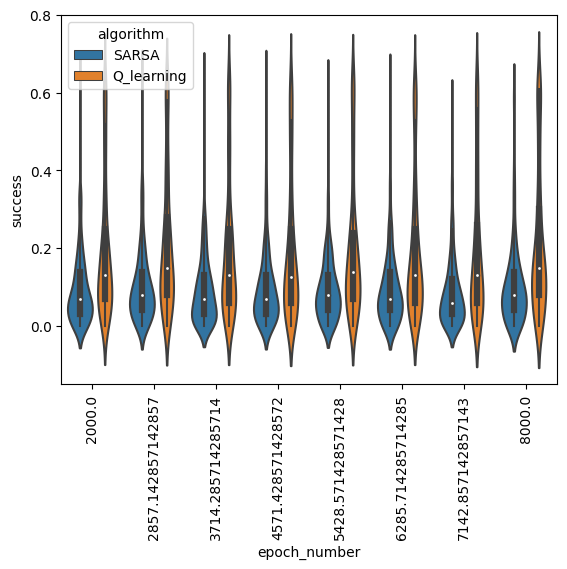

In [9]:
seaborn.violinplot(data=big_df, x="epoch_number", y="success", hue="algorithm").tick_params(axis='x', rotation=90)

On remarque:
 - Q-learning semble systématiquement avoir de meilleur résultats que SARSA
 - le paramètre du nombre d'*epoch* ne parait pas très significatif, en tout cas sur la plage de valeurs observées (entre 2000 et 8000). Des tests statistiques plus approfondis pourraient déterminer si tel est le cas, ou non.

 Pour le paramètre $\epsilon$:

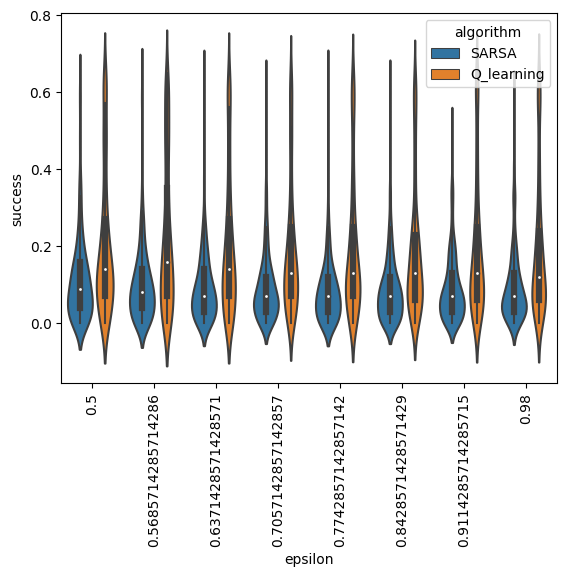

In [10]:
seaborn.violinplot(big_df, x = "epsilon", y= "success", hue='algorithm').tick_params(axis='x', rotation=90)

On remarque:
 - Q-learning semble systématiquement avoir de meilleur résultats que SARSA
 - le paramètre $\epsilon$ ne parait pas très significatif (dit autrement, l'algorithme ne semble pas très sensible au paramètre), en tout cas sur la plage de valeurs observées (entre 0.5 et 0.98). Des tests statistiques plus approfondis pourraient déterminer si tel est le cas, ou non.

 Pour le paramètre $\alpha$:

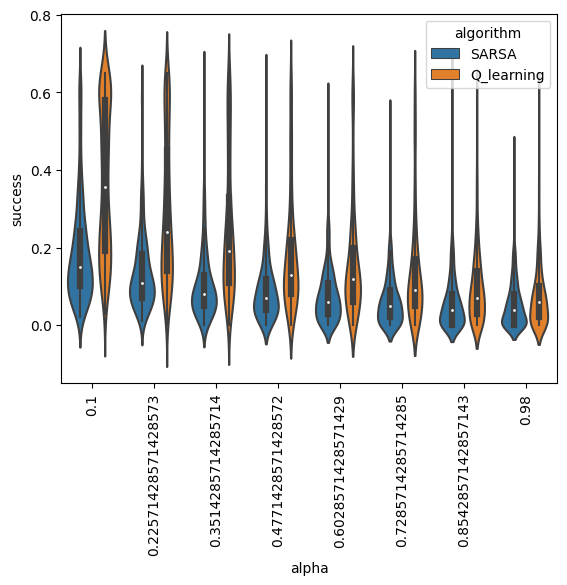

In [11]:
seaborn.violinplot(big_df, x = "alpha", y= "success", hue='algorithm').tick_params(axis='x', rotation=90)

On remarque:
- Q_learning est systématiquement sensiblement meilleur que SARSA
- Le taux de succès des algorithmes semble négativement corrélé  au paramètre $\alpha$
- Une valeur basse est donc meilleure qu'une valeur haute

On pourrait faire une grille autour de 0.1 pour essayer de trouver une valeur encore meilleure que 0.1.

Pour le paramètre $\gamma$: 

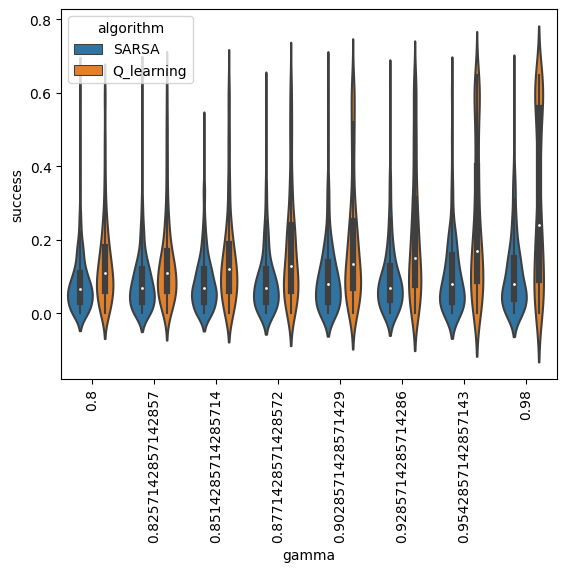

In [12]:
seaborn.violinplot(big_df, x = "gamma", y= "success", hue='algorithm').tick_params(axis='x', rotation=90)

On remarque:
- Q_learning est systématiquement meilleur que SARSA
- Le taux de succès des algorithmes semble positivement corrélé  au paramètre $\gamma$
- Une valeur haute est donc bien meilleure qu'une valeur haute

On pourrait faire une grille autour de 0.98 pour essayer de trouver une valeur encore meilleure que 0.98.

# Convergence

L'étude précédente met en avant un fait "inquiétant": le nombre d'épisodes lors de l'apprentissage ne semble pas positivement corrélé avec un meilleur taux de succès. 

Dit autrement, on ne voit pas de convergence: lors d'une première phase d'exploration, si le taux de succès lors du test ne nous convient pas, on peut relancer l'algorithme ou le prolonger: comment alors automatiser cette tâche ?


Pour illustrer le propos précédent, le graphique suivant représente *n = 10* trajectoires (parmis les meilleures) avec un jeu de paramètre fixe (l'algorithme, $\alpha, \gamma, \epsilon$) en fonction de la durée d'apprentissage.

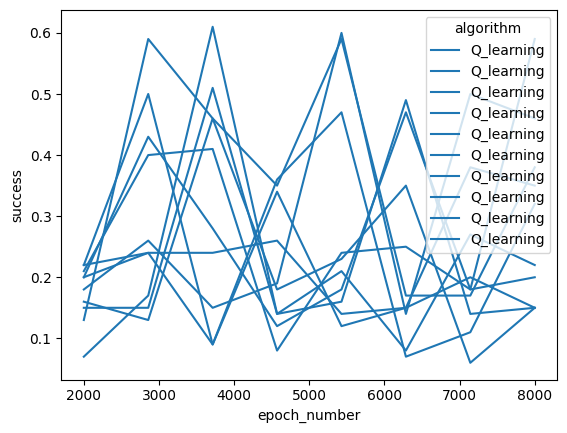

In [13]:


results.sort(reverse=True, key = lambda element: element["success"])
trajectory_number = 10

big_df = pd.DataFrame(results)
target_df = pd.DataFrame()
target_list = []
sub_df = big_df[['alpha', 'gamma', 'algorithm', 'epsilon', 'success', 'epoch_number']]
# See https://stackoverflow.com/a/60909312
# On aggrège les trajectoires en fixant tous les paramètres sauf le nombre d'épisodes
cols = ['algorithm', 'alpha', 'gamma', 'epsilon']
for k, d in sub_df.drop(cols, axis=1).groupby([sub_df[c] for c in cols]):
    out = d
    out["algorithm"] = k[0]
    out["param"] = ",".join([str(i) for i in k])
    out.sort_values("epoch_number", ascending = True, inplace = True)
    target_list.append(out)
fig, ax = plt.subplots()
for line in target_list[0:trajectory_number]:
    seaborn.lineplot(line, x='epoch_number', y='success', hue='algorithm', ax = ax)
plt.show()

On voit que les trajectoires n'atteignent pas forcément leur point le plus haut avec un nombre d'épisodes plus élevés. Il faut également rappeller que le hasard n'y est *pour rien*: on a fixé la graine au début de chaque apprentissage, et de chaque test.

Cela signifie par exemple que la première trajectoire, qui débute avec un taux de réussite inférieure à 0.1, atteint son taux de réussite record de 0.61 entre 3000 et 4000 épisodes d'apprentissages, sur la même séquence d'aléatoire lors du test, pour le voir chuter à environ 0.15 moins de 1000 épisodes d'apprentissages plus loin.


La question est alors quand s'arrêter, afin d'être **certain** d'avoir un bon apprentissage ?

## Critère de convergence

Pour se rendre compte d'une convergence, on va observer une statistique, ou un objet mathématique, qui semble se stabiliser. Une approche naïve, et valide, est d'observer le taux de réussite **de la politique apprise** lors d'une séquence d'épisodes de test. Bien qu'il n'y ait aucune raison que ça ne fonctionne pas, cela semble extrèmement lent: en effet, si l'on souhaite tester selon ce critère lors de chaque épisode d'apprentissage, avec 100 épisodes de test (par exemple) pour tester la convergence, on multiplie grossièrement par 101 le temps d'apprentissage.

La méthode que je propose ici est de directement regarder la forme de la matrice $Q_{s, a}$ lors de chaque itération, pour déterminer si les caractéristiques génératrices de la politique déterministe correspondante évolue. Ce calcul est rapide, et peut donc être effectué "gratuitement" à la fin de chaque épisode d'apprentissage.

Les algorithmes suivants sont des variations de leurs précédentes implémentations, où l'on a arbitrairement fixé à 100 le nombre d'épisodes consécutifs nécessaires à la convergence de la politique apprise: si la matrice $Q_{s, a}$ ne change pas "de forme" pendant 100 épisodes, après un temps de chauffe, on considère que la solution est "stable", et on testera cette solution.

In [14]:
with open("src/Algorithms/Monte_Carlo_controlled.py", 'r', encoding='utf-8') as the_file:
    print(the_file.read())


import numpy as np
from nptyping import Float, NDArray, Shape
import random
from src.Classes.Policy import Policy
from src.Classes.Agent import Agent
from src.Functions.epsilon_greedy_policy_factory import make_epsilon_greedy_policy
from src.Functions.reshape import reshape_one
# Generic Initialisation
def MC(environment, epsilon, warmup_epoch = 500, maximum_epoch = 15000):
    # Get the observation space & the action space
    environment_space_length: int = environment.observation_space.n # type: ignore
    action_space_length: int = environment.action_space.n # type: ignore
    Q_sa = np.zeros((environment_space_length, action_space_length))
    incremental_counter = np.zeros((environment_space_length, action_space_length))
    epsilon_greedy_policy = Policy(
        make_epsilon_greedy_policy(epsilon = epsilon, Q_sa = Q_sa),
        environment_space_length,
        action_space_length
    )

    def update_MC(agent: Agent):
        # All the (state, action) pair got updated with 

**Remarque:** Je ne m'attarderais pas sur cette version "améliorée" de Monte-Carlo, car l'algorithme est beaucoup trop lent, et je n'ai pas encore diagnostiqué les raisons. 

In [15]:
with open("src/Algorithms/Q_learning_controlled.py", 'r', encoding='utf-8') as the_file:
    print(the_file.read())

import gymnasium as gym
import numpy as np
from nptyping import Float, NDArray, Shape

from src.Functions.reshape import reshape_one
from src.Classes.Policy import Policy
from src.Classes.Agent import Agent
from src.Functions.epsilon_greedy_policy_factory import make_epsilon_greedy_policy

def Q_learning(environment, epsilon = 0.1, alpha = 0.1, gamma = 0.99, warmup_epoch = 500, maximum_epoch = 15000):
    # Get the observation space & the action space
    environment_space_length: int = environment.observation_space.n # type: ignore
    action_space_length: int = environment.action_space.n # type: ignore
    Q_sa = np.zeros((environment_space_length, action_space_length))

    epsilon_greedy_policy = Policy(
        make_epsilon_greedy_policy(epsilon = epsilon, Q_sa = Q_sa),
        environment_space_length,
        action_space_length
    )
    def update_Qlearning(agent: Agent, state_index, action_index, next_state, reward: float = 0):
        # Q[s, a] := Q[s, a] + α[r + γ . argmax_

In [16]:
with open("src/Algorithms/SARSA_controlled.py", 'r', encoding='utf-8') as the_file:
    print(the_file.read())

from typing import Callable
import gymnasium as gym
from nptyping import Float, NDArray, Shape
import numpy as np

from src.Classes.Policy import Policy
from src.Classes.Agent import Agent
from src.Functions.epsilon_greedy_policy_factory import make_epsilon_greedy_policy
from src.Functions.reshape import reshape_one
def SARSA(environment, epsilon = 0.1, alpha = 0.1, gamma = 0.99, warmup_epoch = 500, maximum_epoch = 15000):
    # Get the observation space & the action space
    environment_space_length: int = environment.observation_space.n # type: ignore
    action_space_length: int = environment.action_space.n # type: ignore
    Q_sa = np.zeros((environment_space_length, action_space_length))

    epsilon_greedy_policy = Policy(
        make_epsilon_greedy_policy(epsilon = epsilon, Q_sa = Q_sa),
        environment_space_length,
        action_space_length
    )
    def update_SARSA(agent: Agent, state_index: int, action_index: int, next_state: int, next_action: int,  reward:float = 0

### Comparaison de la convergence entre SARSA et Q-learning

Avec le critère de convergence arbitraire énoncé plus haut, on va comparer le temps et le nombre d'epoch nécessaires à l'obtention de notre meilleur politique apprise. On en profitera pour regarder la fiabilité de la méthode. 

Le bloc suivant initialise l'environnement, et définit la procédure de test.

In [17]:
desc=["SFFF", "FHFH", "FFFH", "HFFG"] # Same as the map called "4*4"

environment = gym.make('FrozenLake-v1', desc=desc, is_slippery=True, render_mode="rgb_array")

def test(q_sa, test_epoch = 100):
    deterministic_policy = Policy_V2.buildOptimalPolicyFrom(q_sa)
    success = 0
    test_agent_v1 = Agent(deterministic_policy, initial_state_index = 0)
    for epoch in range(test_epoch):
        run_static(environment, test_agent_v1)
        success += test_agent_v1.current_state_index == (environment.observation_space.n - 1)  # type: ignore
    return success

Le génération du jeu de données pour la comparaison est définie par la fonction `make_Q_learning_vs_SARSA_data` suivante:

In [18]:
def make_Q_learning_vs_SARSA_data():
    results = []
    iterations = 10
    options = {
        "warmup_epoch": 3000,
        "maximum_epoch": 150000,
        "epsilon": 0.2,
        "alpha": 0.1,
        "gamma": 0.99
    }


    for iteration in range(iterations):
        before_SARSA = time.time()
        learning = SARSA(environment, **options)
        after_SARSA = time.time()
        results.append({
            "algorithm": "SARSA",
            "success": test(learning["Q_sa"]),
            "total_epoch": learning["total_epoch"],
            "converged": learning["convergence_attained"],
            "duration": after_SARSA - before_SARSA
        })

        before_Q_learning = time.time()
        learning = Q_learning(environment, **options)
        after_Q_learning = time.time()
        results.append({
            "algorithm": "Q_learning",
            "success": test(learning["Q_sa"]),
            "total_epoch": learning["total_epoch"],
            "converged": learning["convergence_attained"],
            "duration": after_Q_learning - before_Q_learning
        })
    return results

results = save_or_load("data/Q_learning_VS SARSA_controlled.json", make_Q_learning_vs_SARSA_data)
dataframe = pd.DataFrame(results)
print(dataframe)

     algorithm  success  total_epoch  converged   duration
0        SARSA       69        52430       True  13.995751
1   Q_learning       73         3297       True   0.700515
2        SARSA       74        47349       True  12.806160
3   Q_learning       79         3101       True   0.766853
4        SARSA       77        34527       True   9.193797
5   Q_learning       68         3240       True   0.676960
6        SARSA       75         9361       True   2.338806
7   Q_learning       74         3466       True   0.736524
8        SARSA       68        57700       True  15.271079
9   Q_learning       78         3249       True   0.723261
10       SARSA       78        18912       True   5.001256
11  Q_learning       72         3343       True   0.725920
12       SARSA       72        22209       True   5.826157
13  Q_learning       75         3871       True   0.869149
14       SARSA       62        43794       True  11.730431
15  Q_learning       73         3248       True   0.7073

Le premier graphique est un boxplot du succès, c'est à dire qu'on va esquisser la distribution des succès en fonction de l'algorithme, en exposant les valeurs extrêmes et les quartiles/médiane.

<AxesSubplot: xlabel='algorithm', ylabel='success'>

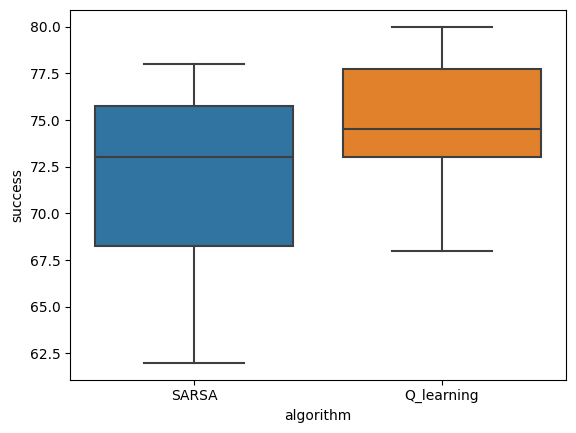

In [19]:
seaborn.boxplot(dataframe, y= "success", x='algorithm')

 On observe pour les deux algorithmes une fiabilité bien supérieure à leur version sans convergence. Pour départager les deux, Q_learning semble à la fois meilleur et plus "stable". En effet le coeur de la distribution et la médiane sont plus haut pour Q_learning, ce qui indique une solution moins fiable. On pourrait penser qu'il s'agit là d'un simple effet du hasard, mais je vous encourage à le tester vous même pour en tirer les mêmes conclusions(pour des raisons de temps et de présentation, je n'ai fait que 10 runs de chaque algorithme).

 De manière analogue, on peut esquisser le nombre d'épisodes jusqu'à la convergence, pour chaque algorithme.

Correlation between epoch number and duration in seconds is 0.9999152950205207
SARSA is 9.822916352902196 slower (on average) than Q-learning


<AxesSubplot: xlabel='algorithm', ylabel='total_epoch'>

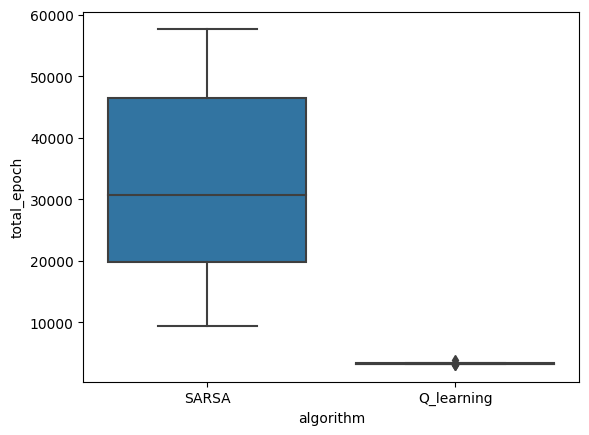

In [20]:
correlation = dataframe["total_epoch"].corr(dataframe["duration"])
times_slower = dataframe.loc[dataframe["algorithm"] == "SARSA", "total_epoch"].mean() / dataframe.loc[dataframe["algorithm"] == "Q_learning", "total_epoch"].mean()
print("Correlation between epoch number and duration in seconds is " + str(correlation))
print("SARSA is " + str(times_slower) + " slower (on average) than Q-learning")
seaborn.boxplot(dataframe, y= "total_epoch", x='algorithm')


On voit ici que SARSA est beaucoup plus variable dans la durée qu'il met jusqu'à la convergence, et aussi beaucoup plus long. Là encore, Q learning est un gagnant clair. J'ai choisi de représenter le nombre total d'épisodes plutot que le temps machine, mais les deux représentent la même chose ici: ils sont très fortement positivement corrélés.

Le graphique suivant est un "scatterplot" du nombre d'épisode en abscisse et du taux de réussite en ordonnée. Il combine les deux graphiques précédents en en faisant la synthèse.

<AxesSubplot: xlabel='total_epoch', ylabel='success'>

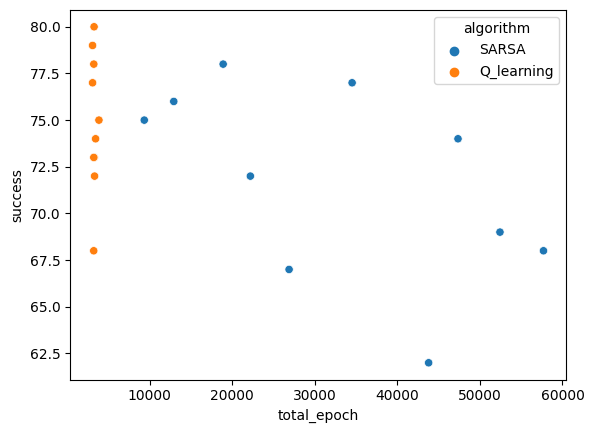

In [21]:
seaborn.scatterplot(dataframe, y= "success", x='total_epoch', hue = "algorithm")

On voit ici que Q-learning est à la fois  récurrement plus rapide, et meilleur, sans aucun résultat laissant penser qu'il à échoué à trouver la politique optimale.

### $\epsilon$*-decay*

On a vu que les algorithmes précédents utilisent lors de l'apprentissage une politique $\epsilon$*-greedy*, et que le paramètre $\epsilon$ ne semblait pas avoir une importance majeure dans les résultats de l'algorithme. En réponse à ce constat, et sur les notions de convergence précédemment évoqués, on a "empiriquement" (je n'ai pas trouvé de preuve historique mathématique du gain de ce fonctionnement, peut être existe-t-elle quelque part cependant) modifié la politique $\epsilon$*-greedy* afin d'avoir un meilleur comportement.

L'algorithme suivant utilise un $\epsilon$*-decay* sur un algorithme de Q-learning: je me suis concentré sur celui-ci, car il parait évident maintenant qu'il est à la fois meilleur, et bien plus rapide.

Voici son implémentation:

In [22]:
with open("src/Algorithms/Q_learning_decay.py", 'r', encoding='utf-8') as the_file:
    print(the_file.read())

import gymnasium as gym
import numpy as np
from nptyping import Float, NDArray, Shape

from src.Classes.Policy import Policy
from src.Classes.Agent import Agent
from src.Functions.epsilon_greedy_policy_factory import make_epsilon_greedy_policy

def Q_learning(environment, epsilon_decay = 0.01, alpha = 0.1, gamma = 0.99, epoch_number = 5000):
    # Get the observation space & the action space
    environment_space_length: int = environment.observation_space.n # type: ignore
    action_space_length: int = environment.action_space.n # type: ignore
    Q_sa = np.zeros((environment_space_length, action_space_length))


    def update_Qlearning(agent: Agent, state_index, action_index, next_state, reward: float = 0):
        # Q[s, a] := Q[s, a] + α[r + γ . argmax_a {Q(s', a')} - Q(s, a)]
        best_next_action = np.argmax(Q_sa[next_state, ])
        Q_sa[state_index, action_index] = Q_sa[state_index, action_index] + alpha * (reward + gamma * Q_sa[next_state, best_next_action] - Q_sa[state_

On remarque qu'à la place de régler avec un paramètre le taux $\epsilon$, on précise son taux de dégradation $\epsilon$*-decay*, en partant de $\epsilon = 1$ .

Comment l'algorithme se comporte vis à vis de ce paramètre ? Est il aussi "insensible" au $\epsilon$*-decay* qu'il ne l'est pour le $\epsilon$ ?

Le génération du jeu de données pour la comparaison est défini par la fonction `make_epsilon_decay_vs_convergence_controller_data` suivante:

In [23]:
from src.Algorithms.Q_learning_controlled import Q_learning as Q_controlled
from src.Algorithms.Q_learning_decay import Q_learning as Q_decay


def make_epsilon_decay_vs_convergence_controller_data():

    results = []
    iterations = 10

    options_controlled = {
        "warmup_epoch": 3000,
        "maximum_epoch": 150000,
        "epsilon": 0.2,
        "alpha": 0.1,
        "gamma": 0.99
    }

    options_decay = {
        "epoch_number": 5000,
        "alpha": 0.1,
        "gamma": 0.99
    }

    epsilon_decay_values = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005]
    for iteration in range(iterations):
        before = time.time()
        learning = Q_controlled(environment, **options_controlled)
        after = time.time()
        results.append({
            "algorithm": "Q_controlled",
            "success": test(learning["Q_sa"]),
            "duration": after - before
        })
        for epsilon_decay in epsilon_decay_values:
            before = time.time()
            q_sa = Q_decay(environment, **options_decay, epsilon_decay = epsilon_decay)
            after = time.time()
            results.append({
                "algorithm": "Q_decay",
                "success": test(q_sa),
                "epsilon-decay": epsilon_decay,
                "duration": after - before
            })
    return results

results = save_or_load("data/decay_VS_controlled.json", make_epsilon_decay_vs_convergence_controller_data)           


J'effectuerai les comparaisons entre elles (avec plusieurs valeurs de $\epsilon$*-decay*) en parallèle de la méthode avec "contrôle de convergence" précédemment exposé, en dessinant un scatterplot de la durée d'exécution et du succès, en fonction des algorithmes.

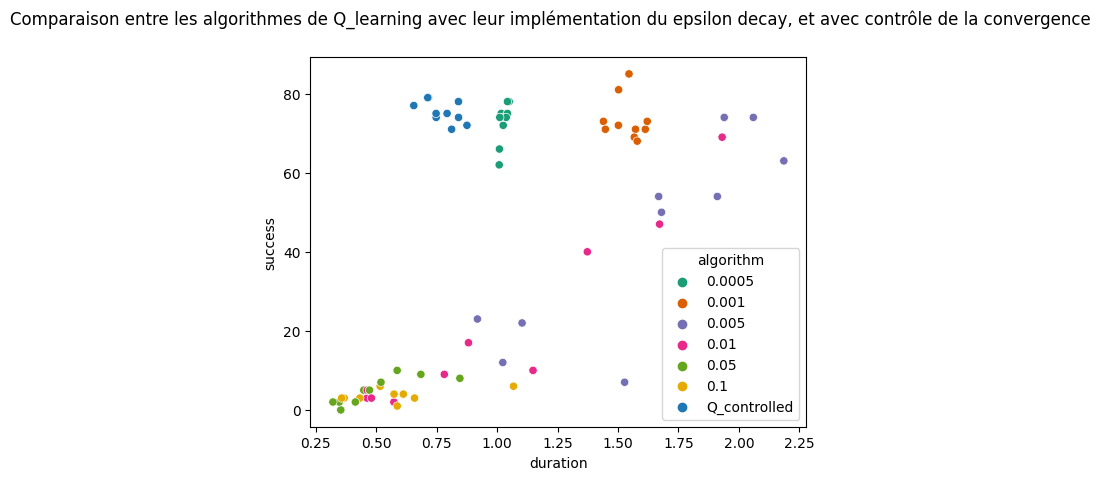

In [24]:
dataframe = pd.DataFrame(results)

fig, axs = plt.subplots()
fig.suptitle("Comparaison entre les algorithmes de Q_learning avec leur implémentation du epsilon decay, et avec contrôle de la convergence")
seaborn.scatterplot(dataframe[dataframe["algorithm"] == "Q_decay"], x = "duration", y = "success", hue = "epsilon-decay", palette="Dark2", ax  = axs)
seaborn.scatterplot(dataframe[dataframe["algorithm"] == "Q_controlled"], x = "duration", y = "success", hue = "algorithm", ax = axs)
plt.show()

On observe au moins deux choses:
- Contrairement au paramètre $\epsilon$, l'algorithme est très sensible au paramètre $\epsilon$*-decay*, comme l'indique la variabilité dans la durée et le taux de réussite pour les différentes valeurs du $\epsilon$*-decay*
- Il faut une valeur suffisement basse pour qu'il estime correctement notre politique optimale, et, pour les valeurs testées, la plus basse semble être la meilleure, tout en étant systématiquement plus lent que la méthode de "contrôle de convergence", et plus variable. Il faudrait faire des tests supplémentaires pour trouver la "meilleure valeur possible" du paramètre $\epsilon$*-decay*

En conclusion, $\epsilon$*-decay* semble être une méthode performante, mais qui demande plus d'analyse au préalable, tandis que la méthode avec contrôle de la convergence semble stable à la faux dans son taux de succès, et dans son temps d'excution. 

# Conclusion

Suite aux analyses précédentes, si je devais choisir une méthode pour traiter un problème généré de **FrozenLake**, je choisirais la méthode avec **Q_learning** avec "contrôle de la convergence", et le jeu de paramètre utilisé dans le rapport. SARSA et MonteCarlo serait éliminé, car je n'ai pas réussi à dégager un scénario dans lequel il aurait un meilleur comportement que Q-learning. Pour la variante avec $\epsilon$*-decay*, il faudrait être certain de bien choisir la valeur du paramètre, car une "erreur" dessus pourrait mener à de mauvais ou inconsistants résultats.


